In [1]:
# Install pyfiglet
!pip install pyfiglet

# Install opencv
!pip install opencv-python

# Install numpy
!pip install numpy

# Install Pillow
!pip install Pillow

import sys
sys.path.append("..") # Adds higher directory to python modules path.

# Import library
from FloorplanToBlenderLib import *

# Other necessary libraries
import cv2 # for image gathering
import numpy as np

# for visualize
from PIL import Image
from IPython.display import display

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.1 MB 960.0 kB/s eta 0:00:02
   ---- ----------------------------------- 0.1/1.1 MB 1.6 MB/s eta 0:00:01
   ---- ----------------------------------- 0.1/1.1 MB 1.6 MB/s eta 0:00:01
   ---- ----------------------------------- 0.1/1.1 MB 1.6 MB/s eta 0:00:01
   ---------- ----------------------------- 0.3/1.1 MB 1.1 MB/s eta 0:00:01
   ------------- -------------------------- 0.4/1.1 MB 1.3 MB/s eta 0:00:01
   ---------------- ----------------------- 0.5/1.1 MB 1.5 MB/s eta 0:00:01
   ---------------------- ----------------- 0.6/1.1 MB 1.6 MB/s eta 0:00:01
   --------------------------- ------------ 0.8/1.1 MB 1.8 MB/s eta 0:00:01
   ------------------------------------- -- 1.0/1.1 MB 2.2 MB/s eta 0:00:01
   ---------------------------------------- 1.1/1.1 MB 2.2 MB/s eta 0:00:00


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


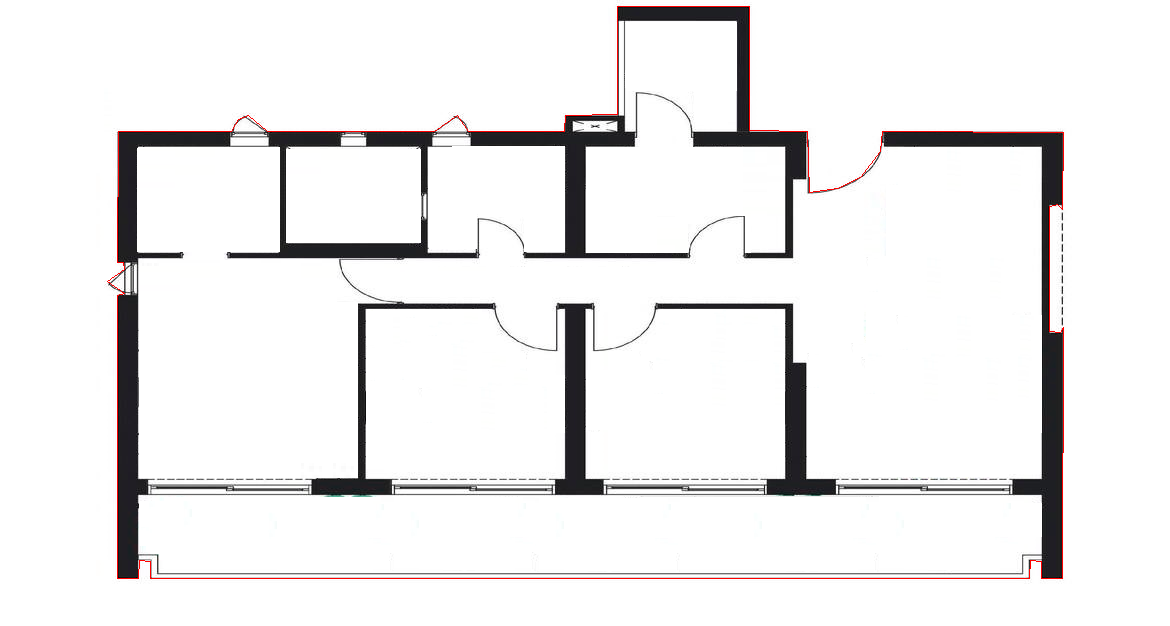

In [3]:
img_path = "D:/FloorplanToBlender3d-master/Images/Examples/BlankLayout.png"

# Read floorplan image
img = cv2.imread(img_path)

# Create blank image
height, width, channels = img.shape
blank_image = img.copy()

# Grayscale image
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# detect outer Contours (simple floor or roof solution), paint them red on blank_image
contour, c_img = detect.outer_contours(gray, blank_image, color=(255,0,0))

# Display
display(Image.fromarray(blank_image))

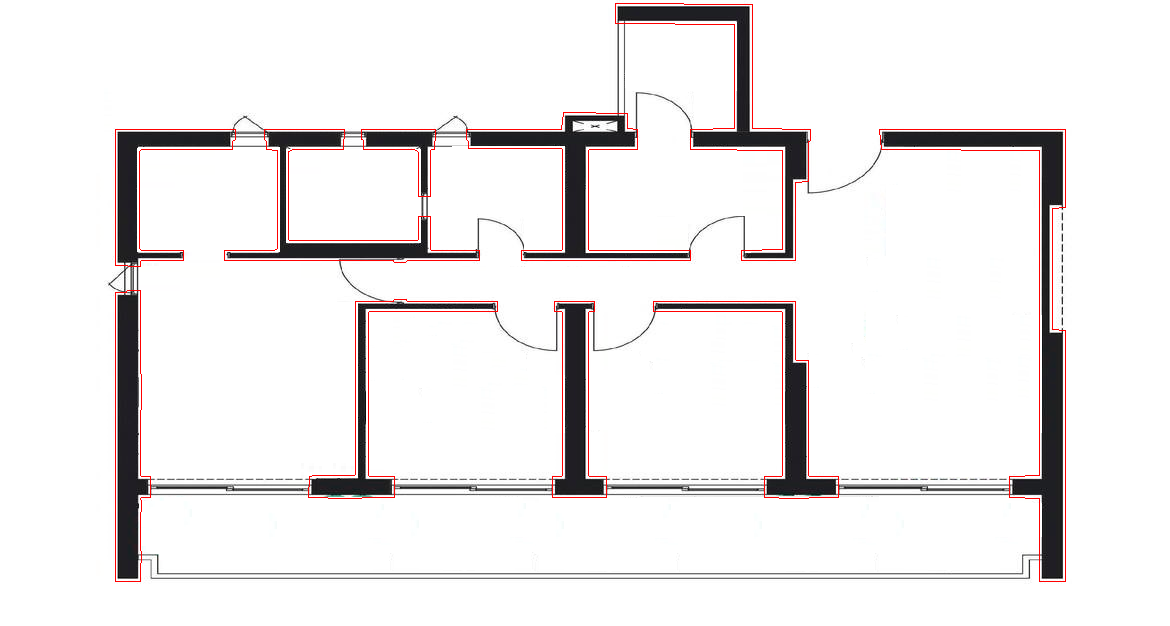

In [5]:
# Create new blank image
blank_image = img.copy()

# Perform filter on grayscaled input image
wall_img = detect.wall_filter(gray)

"""
Detect Wall
"""
boxes, w_img = detect.precise_boxes(wall_img, blank_image, color=[255,0,0])

# Display
display(Image.fromarray(blank_image))

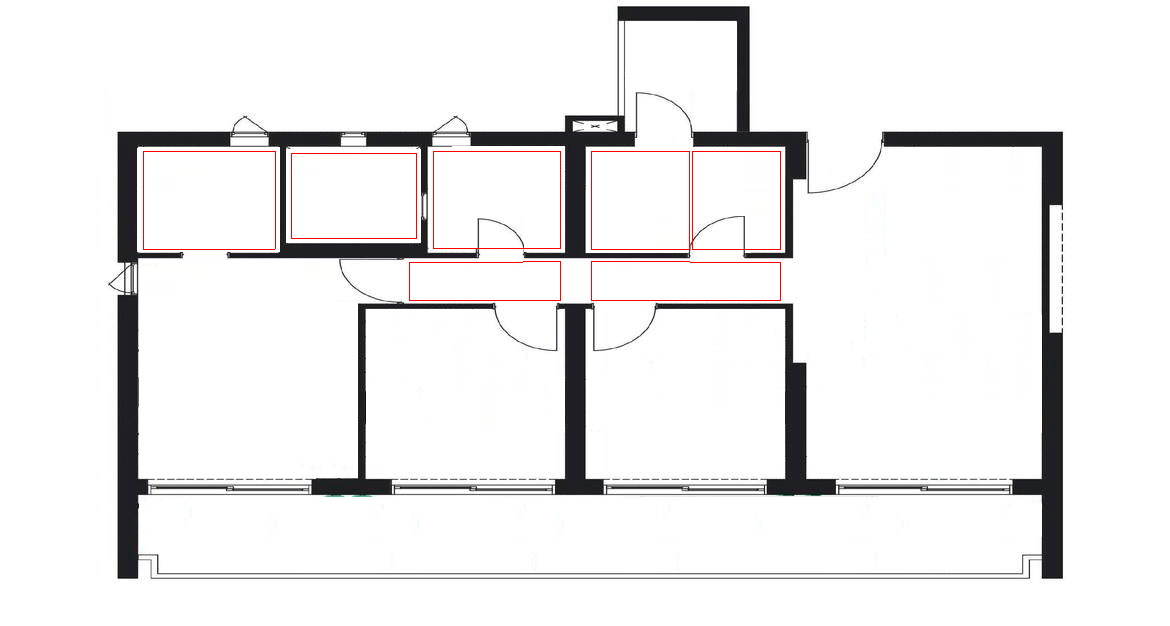

In [7]:
# Create new blank image
blank_image = img.copy()

gray = ~wall_img

# Find rooms
rooms, colored_rooms = detect.find_rooms(gray)

gray_rooms = cv2.cvtColor(colored_rooms, cv2.COLOR_BGR2GRAY)

boxes, blank_image = detect.precise_boxes(
    gray_rooms, blank_image, color=(255, 0, 0)
)

# Display
display(Image.fromarray(blank_image))

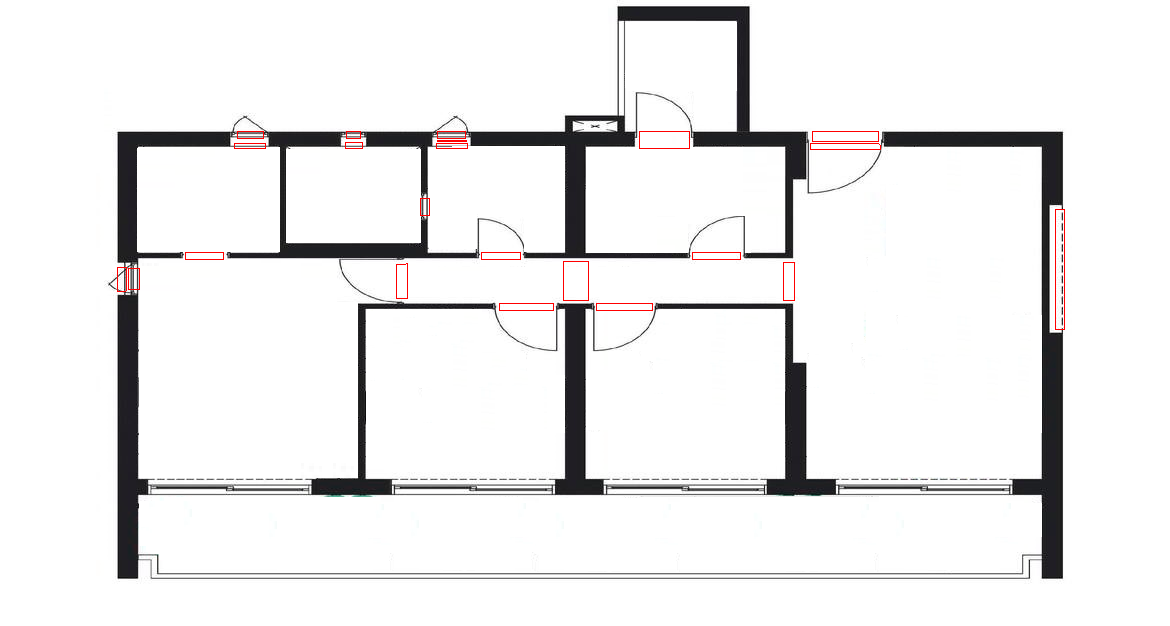

In [9]:
# Create new blank image
blank_image = img.copy()

doors, colored_doors = detect.find_details(gray.copy())
gray_details = cv2.cvtColor(colored_doors, cv2.COLOR_BGR2GRAY)
boxes, blank_image = detect.precise_boxes(
    gray_details, blank_image, color=(255, 0, 0)
)

# Display
display(Image.fromarray(blank_image))

In [259]:
import cv2
import numpy as np
import sys
import os
import math

# Replace with your actual paths
floorplan_lib_path = "D:/FloorplanToBlender3d-master/"
example_image_path = "C:/Users/Aasim.mirza/Downloads/BedroomOp1.png"
door_image_path = "C:/Users/Aasim.mirza/Downloads/slidingwindow.png"

sys.path.insert(0, floorplan_lib_path)
from FloorplanToBlenderLib import *  # Assuming FloorplanToBlenderLib is correctly imported
from subprocess import check_output

def detect_windows_and_doors_boxes(img, door_list):
    height, width, channel = img.shape
    blank_image = np.zeros(
        (height, width, 3), np.uint8
    )  # output image same size as original

    # grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = detect.wall_filter(gray)
    gray = ~gray
    rooms, colored_rooms = detect.find_rooms(gray.copy())
    doors, colored_doors = detect.find_details(gray.copy())
    gray_rooms = cv2.cvtColor(colored_doors, cv2.COLOR_BGR2GRAY)

    # get box positions for rooms
    boxes, gray_rooms = detect.precise_boxes(gray_rooms, blank_image)

    cv2.imshow("input", img)
    cv2.imshow("doors and windows", gray_rooms)
    cv2.imshow("colored", colored_doors)
    cv2.waitKey(0)

    classified_boxes = []
    # classify boxes
    # window, door, none
    for box in boxes:
        obj = dict()
        obj["type"] = "none"

        # is a door inside box?
        isDoor = False
        for door in door_list:

            if points_are_inside_or_close_to_box(door, box):
                obj["type"] = "door"
                obj["box"] = box
                obj["features"] = door
                isDoor = True
                break

        if isDoor:
            classified_boxes.append(obj)
            continue

        # is window?
        x, y, w, h = cv2.boundingRect(box)
        cropped = img[y : y + h, x : x + w]
        # bandpassfilter
        total = np.sum(cropped)
        colored = np.sum(cropped > 0)
        low = 0.001
        high = 0.00459

        amount_of_colored = colored / total

        if low < amount_of_colored < high:
            obj["type"] = "window"
            obj["box"] = box
            classified_boxes.append(obj)

        # is nothing at all

    for box in classified_boxes:

        if box["type"] == "door":
            img = cv2.line(img, box["features"][1], box["features"][2], (0, 0, 255), 5)

        elif box["type"] == "window":
            x, y, w, h = cv2.boundingRect(box["box"])

            start = (x, y)
            end = (x + w, y + h)
            img = cv2.line(img, start, end, (0, 255, 0), 5)

    cv2.imshow("Final result", img)
    cv2.waitKey(0)


def points_are_inside_or_close_to_box(door, box):

    for point in door:
        if rectContainsOrAlmostContains(point, box):
            return True
            break


def rectContainsOrAlmostContains(pt, box):

    x, y, w, h = cv2.boundingRect(box)
    isInside = x < pt[0] < x + w and y < pt[1] < y + h

    almostInside = False

    min_dist = 0
    if w < h:
        min_dist = w
    else:
        min_dist = h

    for point in box:
        dist = abs(point[0][0] - pt[0]) + abs(point[0][1] - pt[1])
        if dist <= min_dist:
            almostInside = True
            break

    return isInside or almostInside


def scale_model_point_to_origin(origin, point, x_scale, y_scale):
    dx, dy = (point[0] - origin[0], point[1] - origin[1])
    return (dx * x_scale, dy * y_scale)


def feature_detect(img):
    """
    Find features in image
    """

    # Initiate ORB detector
    orb = cv2.ORB_create(nfeatures=10000000, scoreType=cv2.ORB_FAST_SCORE)

    # find the keypoints with ORB
    kp = orb.detect(img, None)

    # compute the descriptors with ORB
    kp, des = orb.compute(img, kp)

    # draw only keypoints location,not size and orientation
    img2 = cv2.drawKeypoints(img, kp, img, color=(0, 255, 0), flags=0)
    cv2.imshow("keypoints", img2)
    cv2.waitKey(0)


def feature_match(img1, img2):
    MIN_MATCHES = 20
    cap = img1
    model = img2
    # ORB keypoint detector
    orb = cv2.ORB_create(nfeatures=10000000, scoreType=cv2.ORB_FAST_SCORE)
    # create brute force  matcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    # Compute model keypoints and its descriptors
    kp_model, des_model = orb.detectAndCompute(model, None)
    # Compute scene keypoints and its descriptors
    kp_frame, des_frame = orb.detectAndCompute(cap, None)
    # Match frame descriptors with model descriptors
    matches = bf.match(des_model, des_frame)
    # Sort them in the order of their distance
    matches = sorted(matches, key=lambda x: x.distance)

    # calculate bounds
    # these are important for group matching!
    min_x = math.inf
    min_y = math.inf
    max_x = 0
    max_y = 0

    all_matches_pos = []
    for mat in matches:
        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        # x - columns
        # y - rows
        # Get the coordinates
        (x1, y1) = kp_model[img1_idx].pt

        # bound checks
        if x1 < min_x:
            min_x = x1
        if x1 > max_x:
            max_x = x1

        if y1 < min_y:
            min_y = y1
        if y1 > max_y:
            max_y = y1

    # calculate min/max sizes!
    h = max_y - min_y
    w = max_x - min_x

    # Initialize lists
    list_grouped_matches = []

    # Create a list of objects containing matches  group on nearby matches
    for mat in matches:
        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        # x - columns
        # y - rows
        # Get the coordinates
        (x1, y1) = kp_model[img1_idx].pt
        (x2, y2) = kp_frame[img2_idx].pt
        print("X1::", x1)
        print("x2 ::", x2)
        
        i = 0
        found = False

        for existing_match in list_grouped_matches:
            if (
                abs(existing_match[0][1][0] - x2) < w
                and abs(existing_match[0][1][1] - y2) < h
            ):
                # add to group
                list_grouped_matches[i].append(((int(x1), int(y1)), (int(x2), int(y2))))
                found = True
                break
            # increment
            i += 1

        if not found:
            tmp = []
            tmp.append(((int(x1), int(y1)), (int(x2), int(y2))))
            list_grouped_matches.append(tmp)

    # Remove groups with only singles because we cant calculate rotation then!
    list_grouped_matches_filtered = []

    for match_group in list_grouped_matches:
        if len(match_group) >= 4:
            list_grouped_matches_filtered.append(match_group)

    # print(list_grouped_matches_filtered, len(list_grouped_matches_filtered))

    # find corners of door in model image
    corners = cv2.goodFeaturesToTrack(model, 3, 0.01, 10)
    corners = np.int8(corners)

    # This is still a little hardcoded but still better than before!
    upper_left = corners[1][0]
    upper_right = corners[0][0]
    down = corners[2][0]

    max_x = 0
    max_y = 0
    min_x = math.inf
    min_y = math.inf

    for cr in corners:
        x1 = cr[0][0]
        y1 = cr[0][1]

        if x1 < min_x:
            min_x = x1
        if x1 > max_x:
            max_x = x1

        if y1 < min_y:
            min_y = y1
        if y1 > max_y:
            max_y = y1

    origin = (int((max_x + min_x) / 2), int((min_y + max_y) / 2))

    list_of_proper_transformed_doors = []

    doors_actual_pos = []
    # Calculate position and rotation of doors
    for match in list_grouped_matches_filtered:

        # calculate offsets from points
        index1, index2 = calculate_best_matches_with_modulus_angle(match)

        pos1_model = match[index1][0]
        pos2_model = match[index2][0]

        # calculate actual position from offsets with rotation!
        pos1_cap = match[index1][1]
        pos2_cap = match[index2][1]

        pt1 = (pos1_model[0] - pos2_model[0], pos1_model[1] - pos2_model[1])
        pt2 = (pos1_cap[0] - pos2_cap[0], pos1_cap[1] - pos2_cap[1])

        ang = math.degrees(angle(pt1, pt2))
        # print(index1, index2, ang)

        # print("Angle between doors ", ang)

        # rotate door
        new_upper_left = rotate(origin, upper_left, math.radians(ang))
        new_upper_right = rotate(origin, upper_right, math.radians(ang))
        new_down = rotate(origin, down, math.radians(ang))

        new_pos1_model = rotate(origin, pos1_model, math.radians(ang))

        # calculate scale, and rescale model
        """
        new_cap1 = rotate(origin, pos1_cap, math.radians(ang))
        new_cap2 = rotate(origin, pos2_cap, math.radians(ang))
        new_model1 = rotate(origin, pos1_model, math.radians(ang))
        new_model2 = rotate(origin, pos2_model, math.radians(ang))

        cap_size = [(new_cap1[0]- new_cap2[0]), (new_cap1[1]- new_cap2[1])]
        model_size = [(new_model1[0]-new_model2[0]),(new_model1[1]-new_model2[1])]
        
        
        if cap_size[1] != 0 or model_size[1] != 0:
            x_scale = abs(cap_size[0]/model_size[0])
            y_scale = abs(cap_size[1]/model_size[1])
            print(x_scale, y_scale)
            scaled_upper_left = scale_model_point_to_origin( origin, new_upper_left,x_scale, y_scale)
            #scaled_upper_right = scale_model_point_to_origin( origin, new_upper_right,x_scale, y_scale)
            #scaled_down = scale_model_point_to_origin( origin, new_down,x_scale, y_scale)
            scaled_pos1_model = scale_model_point_to_origin( origin, new_pos1_model,x_scale, y_scale)
        else:
        """
        scaled_upper_left = new_upper_left
        scaled_upper_right = new_upper_right
        scaled_down = new_down
        scaled_pos1_model = new_pos1_model

        offset = (
            scaled_pos1_model[0] - pos1_model[0],
            scaled_pos1_model[1] - pos1_model[1],
        )

        # calculate dist!
        move_dist = (pos1_cap[0] - pos1_model[0], pos1_cap[1] - pos1_model[1])

        # draw corners!
        moved_new_upper_left = (
            int(scaled_upper_left[0] + move_dist[0] - offset[0]),
            int(scaled_upper_left[1] + move_dist[1] - offset[1]),
        )
        moved_new_upper_right = (
            int(scaled_upper_right[0] + move_dist[0] - offset[0]),
            int(scaled_upper_right[1] + move_dist[1] - offset[1]),
        )
        moved_new_down = (
            int(scaled_down[0] + move_dist[0] - offset[0]),
            int(scaled_down[1] + move_dist[1] - offset[1]),
        )

        img = cv2.circle(
            cap, moved_new_upper_left, radius=4, color=(0, 0, 0), thickness=5
        )
        img = cv2.circle(
            cap, moved_new_upper_right, radius=4, color=(0, 0, 0), thickness=5
        )
        img = cv2.circle(cap, moved_new_down, radius=4, color=(0, 0, 0), thickness=5)

        list_of_proper_transformed_doors.append(
            [moved_new_upper_left, moved_new_upper_right, moved_new_down]
        )

    # draw door points
    for match in list_grouped_matches_filtered:

        img = cv2.circle(
            cap,
            (match[0][1][0], match[0][1][1]),
            radius=4,
            color=(0, 0, 0),
            thickness=5,
        )

    # Draw matches as lines
    if len(matches) > MIN_MATCHES:

        # draw first 15 matches.
        cap = cv2.drawMatches(
            model, kp_model, cap, kp_frame, matches[:MIN_MATCHES], 0, flags=2
        )
        # show result
        cv2.imshow("frame", cap)
        cv2.waitKey(0)

    else:
        print(
            "Not enough matches have been found - %d/%d" % (len(matches), MIN_MATCHES)
        )

    return list_of_proper_transformed_doors


def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy


def angle(vector1, vector2):
    x1, y1 = vector1
    x2, y2 = vector2
    inner_product = x1 * x2 + y1 * y2
    len1 = math.hypot(x1, y1)
    len2 = math.hypot(x2, y2)
    return math.acos(inner_product / (len1 * len2))


def average(lst):
    return sum(lst) / len(lst)


def calculate_best_matches_with_modulus_angle(match_list):
    # calculate best matches by looking at the most significant feature distances
    index1 = 0
    index2 = 0
    best = math.inf

    i = 0
    for match1 in match_list:
        j = 0
        for match2 in match_list:

            pos1_model = match_list[i][0]
            pos2_model = match_list[j][0]

            pos1_cap = match_list[i][1]
            pos2_cap = match_list[j][1]

            pt1 = (pos1_model[0] - pos2_model[0], pos1_model[1] - pos2_model[1])
            pt2 = (pos1_cap[0] - pos2_cap[0], pos1_cap[1] - pos2_cap[1])

            if pt1 == pt2 or pt1 == (0, 0) or pt2 == (0, 0):
                continue

            ang = math.degrees(angle(pt1, pt2))
            diff = ang % 30

            if diff < best:
                best = diff
                index1 = i
                index2 = j

            j += 1
        i += 1
    return index1, index2


if __name__ == "__main__":
    img0 = cv2.imread(example_image_path)
    img1 = cv2.imread(example_image_path, 0)
    img2 = cv2.imread(door_image_path, 0)

    detect_windows_and_doors_boxes(img0, feature_match(img1, img2))


X1:: 1460.0
x2 :: 415.0
X1:: 1460.0
x2 :: 421.0
X1:: 1461.60009765625
x2 :: 1196.6400146484375
X1:: 99.36000061035156
x2 :: 1086.912109375
X1:: 98.49600982666016
x2 :: 1083.9124755859375
X1:: 97.45921325683594
x2 :: 713.3184814453125
X1:: 1461.60009765625
x2 :: 711.6000366210938
X1:: 98.49600982666016
x2 :: 711.3600463867188
X1:: 1461.88818359375
x2 :: 711.3600463867188
X1:: 95.551513671875
x2 :: 749.9520874023438
X1:: 99.60000610351562
x2 :: 478.8000183105469
X1:: 1463.1324462890625
x2 :: 1195.776123046875
X1:: 1460.4000244140625
x2 :: 418.0
X1:: 1465.5213623046875
x2 :: 478.8000183105469
X1:: 1459.2000732421875
x2 :: 414.0000305175781
X1:: 795.6000366210938
x2 :: 705.6000366210938
X1:: 1454.7718505859375
x2 :: 481.20001220703125
X1:: 1454.7718505859375
x2 :: 481.20001220703125
X1:: 1458.35498046875
x2 :: 480.96002197265625
X1:: 765.5040893554688
x2 :: 708.4800415039062
X1:: 765.6000366210938
x2 :: 691.5540771484375
X1:: 791.424072265625
x2 :: 711.3600463867188
X1:: 1458.1558837890625

In [228]:
def feature_match1(img1, img2):
    MIN_MATCHES = 20
    cap = img1
    model = img2
    # ORB keypoint detector
    orb = cv2.ORB_create(nfeatures=10000000, scoreType=cv2.ORB_FAST_SCORE)
    # create brute force  matcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    # Compute model keypoints and its descriptors
    kp_model, des_model = orb.detectAndCompute(model, None)
    # Compute scene keypoints and its descriptors
    kp_frame, des_frame = orb.detectAndCompute(cap, None)
    # Match frame descriptors with model descriptors
    matches = bf.match(des_model, des_frame)
    # Sort them in the order of their distance
    matches = sorted(matches, key=lambda x: x.distance)
    print(matches)

In [232]:
if __name__ == "__main__":
    img0 = cv2.imread(example_image_path)
    img1 = cv2.imread(example_image_path, 0)
    img2 = cv2.imread(door_image_path, 0)

    feature_match1(img1, img2)

[< cv2.DMatch 00000233A6CF9450>, < cv2.DMatch 00000233A6CFAC10>, < cv2.DMatch 00000233A6CFB210>, < cv2.DMatch 00000233A6CF9B10>, < cv2.DMatch 00000233A6CFABB0>, < cv2.DMatch 00000233A6CFAB90>, < cv2.DMatch 00000233A6CFAB10>, < cv2.DMatch 00000233A6CF95D0>, < cv2.DMatch 00000233A6CFAF90>, < cv2.DMatch 00000233A6CFAFD0>, < cv2.DMatch 00000233A6CFAB50>, < cv2.DMatch 00000233A6CFAE70>, < cv2.DMatch 00000233A6CFAFB0>, < cv2.DMatch 00000233A6CFABF0>, < cv2.DMatch 00000233A6CFA9F0>, < cv2.DMatch 00000233A6CFAA30>, < cv2.DMatch 00000233A6CFA9B0>, < cv2.DMatch 00000233A6CFA8F0>, < cv2.DMatch 00000233A6CFA990>, < cv2.DMatch 00000233A6CFA490>, < cv2.DMatch 00000233A6CFAB30>, < cv2.DMatch 00000233A6CFABD0>, < cv2.DMatch 00000233A6CFB010>, < cv2.DMatch 00000233A6CFA8D0>, < cv2.DMatch 00000233A6CFAFF0>, < cv2.DMatch 00000233A6CFAB70>, < cv2.DMatch 00000233A6CFA650>, < cv2.DMatch 00000233A6CFA890>, < cv2.DMatch 00000233A6CFAC30>]


In [60]:
#Brief
!pip install opencv-contrib-python

import numpy as np
import cv2 as cv
ori = cv.imread("D:/FloorplanToBlender3d-master/Images/Examples/BlankLayout.png")
img = cv.imread("D:/FloorplanToBlender3d-master/Images/Examples/BlankLayout.png",0)
star = cv.xfeatures2d.StarDetector_create()
brief = cv.xfeatures2d.BriefDescriptorExtractor_create()
kp = star.detect(img,None)
kp, des = brief.compute(img, kp)
print( brief.descriptorSize() )
print( des.shape )
img2 = cv.drawKeypoints(img, kp, None, color=(0, 255, 0), flags=0)
cv.imshow('Original', ori)
cv.imshow('BRIEF', img2)

Defaulting to user installation because normal site-packages is not writeable
  Using cached opencv_contrib_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_contrib_python-4.10.0.84-cp37-abi3-win_amd64.whl (45.5 MB)


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Aasim.mirza\\AppData\\Roaming\\Python\\Python312\\site-packages\\cv2\\cv2.pyd'
Check the permissions.



AttributeError: module 'cv2' has no attribute 'xfeatures2d'

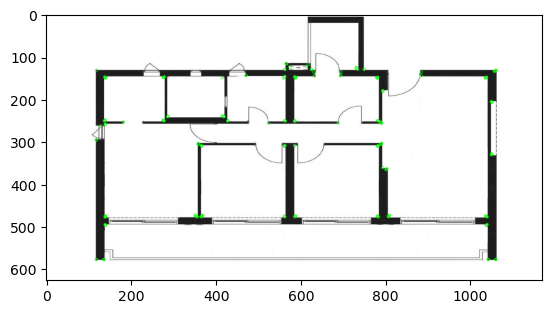

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
ori = cv2.imread("D:/FloorplanToBlender3d-master/Images/Examples/BlankLayout.png") 
img = cv2.imread("D:/FloorplanToBlender3d-master/Images/Examples/BlankLayout.png", 0)
orb = cv2.ORB_create(nfeatures=200)
kp = orb.detect(img, None)
kp, des = orb.compute(img, kp)
img2 = cv2.drawKeypoints(img, kp, None, color=(0, 255, 0), flags=0)
plt.imshow(ori)
plt.imshow(img2)

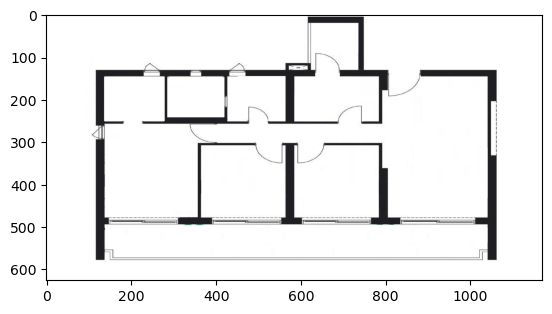

In [11]:
plt.imshow(ori)

In [5]:
import cv2
img1 = cv2.imread("C:/Users/Aasim.mirza/Downloads/BedroomOp1.png", 0)
img1=cv2.resize(img1, (512, 512))
img2 = cv2.imread("C:/Users/Aasim.mirza/Downloads/slidingwindow.png", 0)
img2 = cv2.resize(img2, (400,246))
img2.shape

(246, 400)

In [7]:

orb = cv2.ORB_create(nfeatures=500, scaleFactor=1.2, nlevels=8, edgeThreshold=10, firstLevel=0, WTA_K=2, scoreType=cv2.ORB_HARRIS_SCORE, patchSize=10, fastThreshold=40)
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)
print(des2)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)
match_img = cv2.drawMatches(img1, kp1, img2, kp2, matches[:50], None)
cv2.imshow('original image', img1)
cv2.imshow('test image', img2)
cv2.imshow('Matches', match_img)
cv2.waitKey()


[[ 91  21 156 ...   0 208   5]
 [ 95  21 156 ... 128 210  37]
 [160   0 172 ...  16 112  36]
 ...
 [ 82  85 156 ...   0 210 165]
 [ 90  85 156 ...   0 210 165]
 [ 91  85 156 ...   8 208 173]]


-1

In [15]:
    # Initialize lists
list_grouped_matches = []
i = 0
found = False

In [21]:
for existing_match in list_grouped_matches:
            print("HHHHIiiiiiiiii")
            if (
                abs(existing_match[0][1][0] - 1) < w
                and abs(existing_match[0][1][1] - 1) < h
            ):
                # add to group
                list_grouped_matches[i].append(((int(1), int(1)), (int(2), int(2))))
                found = True
                break
            # increment
            i += 1

In [19]:
list_grouped_matches

[]

In [59]:
from __future__ import print_function
import cv2 as cv
import numpy as np
import argparse
import random as rng
 
source_window = 'Image'
maxTrackbar = 100
rng.seed(12345)
 
def goodFeaturesToTrack_Demo(val):
    maxCorners = max(val, 1)
    
    # Parameters for Shi-Tomasi algorithm
    qualityLevel = 0.01
    minDistance = 10
    blockSize = 3
    gradientSize = 3
    useHarrisDetector = False
    k = 0.04
    
    # Copy the source image
    copy = np.copy(src)
    
    # Apply corner detection
    corners = cv.goodFeaturesToTrack(src_gray, maxCorners, qualityLevel, minDistance, None, \
    blockSize=blockSize, gradientSize=gradientSize, useHarrisDetector=useHarrisDetector, k=k)
    
    # Draw corners detected
    print('** Number of corners detected:', corners.shape[0])
    radius = 4
    for i in range(corners.shape[0]):
        cv.circle(copy, (int(corners[i,0,0]), int(corners[i,0,1])), radius, (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256)), cv.FILLED)
    
    # Show what you got
    cv.namedWindow(source_window)
    cv.imshow(source_window, copy)
 
# Load source image and convert it to gray
parser = argparse.ArgumentParser(description='Code for Shi-Tomasi corner detector tutorial.')
parser.add_argument('--input', help='Path to input image.', default='pic3.png')
args = parser.parse_args()
 
src = cv.imread(cv.samples.findFile(args.input))
if src is None:
    print('Could not open or find the image:', args.input)
    exit(0)
 
src_gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
 
# Create a window and a trackbar
cv.namedWindow(source_window)
maxCorners = 23 # initial threshold
cv.createTrackbar('Threshold: ', source_window, maxCorners, maxTrackbar, goodFeaturesToTrack_Demo)
cv.imshow(source_window, src)
goodFeaturesToTrack_Demo(maxCorners)
 
cv.waitKey()

usage: ipykernel_launcher.py [-h] [--input INPUT]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\Aasim.mirza\AppData\Roaming\jupyter\runtime\kernel-45bddcd0-2958-47fd-90f8-7fea9b02f50f.json


SystemExit: 2

Number of connected components (including background): 3
Labeled image:
 [[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 0 0 0 0 0]
 [0 0 1 1 1 0 0 0 0 0]
 [0 0 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 2 2 0]
 [0 0 0 0 0 0 2 2 2 0]
 [0 0 0 0 0 0 2 2 2 0]
 [0 0 0 0 0 0 0 0 0 0]]


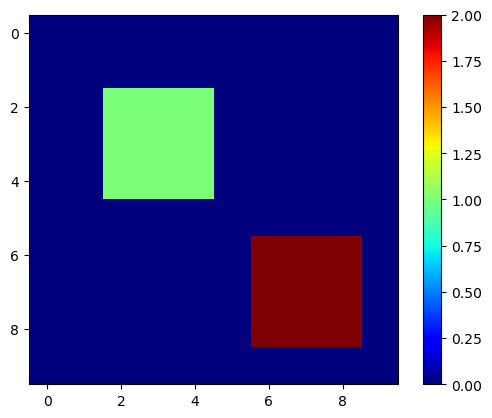

In [67]:
import cv2
import numpy as np

# Create a binary image (foreground objects are white, background is black)
binary_image = np.zeros((10, 10), dtype=np.uint8)
binary_image[2:5, 2:5] = 1  # First object
binary_image[6:9, 6:9] = 1  # Second object

# Find connected components with 8-connectivity
num_labels, labels = cv2.connectedComponents(binary_image, connectivity=8)

# Display the results
print("Number of connected components (including background):", num_labels)
print("Labeled image:\n", labels)

# Optionally visualize the labeled image
import matplotlib.pyplot as plt
plt.imshow(labels, cmap='jet')
plt.colorbar()
plt.show()


In [73]:
DOOR_MODEL = "Images/Models/Doors/Krisumi Bedroom.png"  # TODO: make dynamic folder solution, to add more doors!
DOOR_WIDTH = 5


WINDOWS_AND_DOORS_FEATURE_N = 10000000
WINDOWS_AND_DOORS_MAX_CORNERS = 4
WINDOWS_AND_DOORS_FEATURE_TRACK_MAX_CORNERS = 3
WINDOWS_AND_DOORS_FEATURE_TRACK_QUALITY = 0.01
WINDOWS_AND_DOORS_FEATURE_TRACK_MIN_DIST = 20

DOOR_ANGLE_HIT_STEP = 30  # Preferably evenly dividable with 360

WINDOWS_COLORED_PIXELS_THRESHOLD = [0.001, 0.00459]
WINDOWS_RESCALE_TO_FIT = 1.05


DETAILS_NOISE_REMOVAL_THRESHOLD = 50
DETAILS_CORNERS_THRESHOLD = 0.01
DETAILS_CLOSING_MAX_LENGTH = 130
DETAILS_GAP_IN_WALL_THRESHOLD = [10, 5000]


In [89]:
def remove_noise(img, noise_removal_threshold):
    """
    Remove noise from image and return mask
    Help function for finding room
    @Param img @mandatory image to remove noise from
    @Param noise_removal_threshold @mandatory threshold for noise
    @Return return new mask of image
    """
    img[img < 128] = 0
    img[img > 128] = 255
    contours, _ = cv2.findContours(~img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(img)
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > noise_removal_threshold:
            cv2.fillPoly(mask, [contour], 255)
    return mask


In [97]:
def corners_and_draw_lines(img, corners_threshold, room_closing_max_length):
    """
    Finds corners and draw lines from them
    Help function for finding room
    @Param image input image
    @Param corners_threshold threshold for corner distance
    @Param room_closing_max_length threshold for room max size
    @Return output image
    """
    # Detect corners (you can play with the parameters here)
    kernel = np.ones(const.PRECISE_HARRIS_KERNEL_SIZE, np.uint8)

    dst = cv2.cornerHarris(
        img,
        const.PRECISE_HARRIS_BLOCK_SIZE,
        const.PRECISE_HARRIS_KSIZE,
        const.PRECISE_HARRIS_K,
    )
    dst = cv2.erode(dst, kernel, iterations=const.PRECISE_ERODE_ITERATIONS)
    corners = dst > corners_threshold * dst.max()

    # Draw lines to close the rooms off by adding a line between corners on the same x or y coordinate
    # This gets some false positives.
    # You could try to disallow drawing through other existing lines for example.
    for y, row in enumerate(corners):
        x_same_y = np.argwhere(row)
        for x1, x2 in zip(x_same_y[:-1], x_same_y[1:]):

            if x2[0] - x1[0] < room_closing_max_length:
                color = 0
                cv2.line(img, (x1[0], y), (x2[0], y), color, 1)

    for x, col in enumerate(corners.T):
        y_same_x = np.argwhere(col)
        for y1, y2 in zip(y_same_x[:-1], y_same_x[1:]):
            if y2[0] - y1[0] < room_closing_max_length:
                color = 0
                cv2.line(img, (x, y1[0]), (x, y2[0]), color, 1)
    return img



In [102]:
def mark_outside_black(img, mask):
    """
    Mark white background as black
    @Param @mandatory img image input
    @Param @mandatory mask mask to use
    @Return image, mask
    """
    # Mark the outside of the house as black
    contours, _ = cv2.findContours(~img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_sizes = [(cv2.contourArea(contour), contour) for contour in contours]
    biggest_contour = max(contour_sizes, key=lambda x: x[0])[1]
    mask = np.zeros_like(mask)
    cv2.fillPoly(mask, [biggest_contour], 255)
    img[mask == 0] = 0
    return img, mask


def detect_wall_rescale(reference_size, image):  # TODO: print if image is rescaled!
    """
    detect how much an image is to be rescaled
    """
    image_wall_size = calculate.wall_width_average(image)
    if image_wall_size is None:  # No walls could be found!
        return None
    return calculate_scale_factor(float(reference_size), image_wall_size)


[0 1]
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


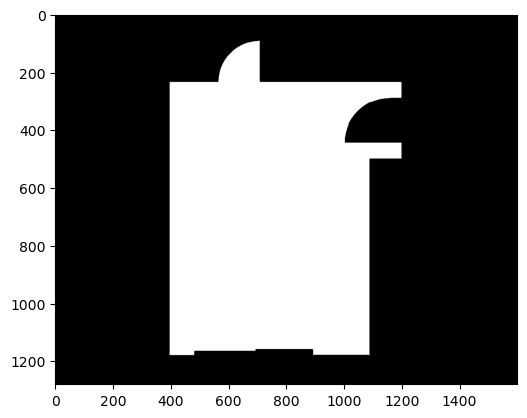

In [252]:

floorplan_lib_path = "D:/FloorplanToBlender3d-master/"
example_image_path = "C:/Users/Aasim.mirza/Downloads/BedroomOp1.png"
door_image_path = "C:/Users/Aasim.mirza/Downloads/slidingwindow.png"

sys.path.insert(0, floorplan_lib_path)
from FloorplanToBlenderLib import *  # Assuming FloorplanToBlenderLib is correctly imported
from subprocess import check_output

def feature_match(img1, img2):
    """
    Feature match models to floorplans in order to distinguish doors from windows.
    Also calculate where doors should exist.
    Compares result with detailed boxes and filter depending on colored pixels to deviate windows, doors and unknowns.
    """
    cap = img1
    model = img2
    # ORB keypoint detector
    orb = cv2.ORB_create(
        nfeatures=WINDOWS_AND_DOORS_FEATURE_N, scoreType=cv2.ORB_FAST_SCORE
    )
    # create brute force  matcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    # Compute model keypoints and its descriptors
    kp_model, des_model = orb.detectAndCompute(model, None)
    # Compute scene keypoints and its descriptors
    kp_frame, des_frame = orb.detectAndCompute(cap, None)
    # Match frame descriptors with model descriptors
    matches = bf.match(des_model, des_frame)
    # Sort them in the order of their distance
    matches = sorted(matches, key=lambda x: x.distance)

    # --- calculate bounds ---

    # these are important for group matching!
    min_x = math.inf
    min_y = math.inf
    max_x = 0
    max_y = 0

    for mat in matches:
        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx

        # x - columns
        # y - rows
        # Get the coordinates
        (x1, y1) = kp_model[img1_idx].pt

        # bound checks
        if x1 < min_x:
            min_x = x1
        if x1 > max_x:
            max_x = x1

        if y1 < min_y:
            min_y = y1
        if y1 > max_y:
            max_y = y1

    # calculate min/max sizes!
    h = max_y - min_y
    w = max_x - min_x

    # Initialize lists
    list_grouped_matches = []

    # --- Create a list of objects containing matches group on nearby matches ---

    for mat in matches:
        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        # Get the coordinates
        # x - columns
        # y - rows
        (x1, y1) = kp_model[img1_idx].pt
        (x2, y2) = kp_frame[img2_idx].pt
        i = 0
        found = False

        for existing_match in list_grouped_matches:
            if (
                abs(existing_match[0][1][0] - x2) < w
                and abs(existing_match[0][1][1] - y2) < h
            ):
                # add to group
                list_grouped_matches[i].append(((int(x1), int(y1)), (int(x2), int(y2))))
                found = True
                break
            # increment
            i += 1

        if not found:
            tmp = []
            tmp.append(((int(x1), int(y1)), (int(x2), int(y2))))
            list_grouped_matches.append(tmp)

    # Remove groups with only singles because we cant calculate rotation then!
    list_grouped_matches_filtered = []
    for match_group in list_grouped_matches:
        if len(match_group) >= WINDOWS_AND_DOORS_MAX_CORNERS:
            list_grouped_matches_filtered.append(match_group)

    # find corners of door in model image
    corners = cv2.goodFeaturesToTrack(
        model,
        WINDOWS_AND_DOORS_FEATURE_TRACK_MAX_CORNERS,
        WINDOWS_AND_DOORS_FEATURE_TRACK_QUALITY,
        WINDOWS_AND_DOORS_FEATURE_TRACK_MIN_DIST,
    )
    # Check if corners are found
    if corners is not None:
        corners = np.int8(corners)  # Use np.int0 to properly convert to integer type

        # This is still a little hardcoded but still better than before!
        upper_left = corners[1][0]
        upper_right = corners[0][0]
        down = corners[2][0]

        max_x = 0
        max_y = 0
        min_x = math.inf
        min_y = math.inf

        for cr in corners:
            x1 = cr[0][0]
            y1 = cr[0][1]

            if x1 < min_x:
                min_x = x1
            if x1 > max_x:
                max_x = x1

            if y1 < min_y:
                min_y = y1
            if y1 > max_y:
                max_y = y1

        origin = (int((max_x + min_x) / 2), int((min_y + max_y) / 2))

        list_of_proper_transformed_doors = []
    else:
        raise ValueError("No corners found in the model image. Please check the input image or adjust the parameters.")
        # Calculate position and rotation of doors
    for match in list_grouped_matches_filtered:

        # calculate offsets from points
        index1, index2 = best_matches_with_modulus_angle(match)

        pos1_model = match[index1][0]
        pos2_model = match[index2][0]

        # calculate actual position from offsets with rotation!
        pos1_cap = match[index1][1]
        pos2_cap = match[index2][1]

        pt1 = (pos1_model[0] - pos2_model[0], pos1_model[1] - pos2_model[1])
        pt2 = (pos1_cap[0] - pos2_cap[0], pos1_cap[1] - pos2_cap[1])

        ang = math.degrees(angle_between_vectors_2d(pt1, pt2))

        # rotate door
        new_upper_left = rotate_round_origin_vector_2d(
            origin, upper_left, math.radians(ang)
        )
        new_upper_right = rotate_round_origin_vector_2d(
            origin, upper_right, math.radians(ang)
        )
        new_down = rotate_round_origin_vector_2d(
            origin, down, math.radians(ang)
        )
        new_pos1_model = rotate_round_origin_vector_2d(
            origin, pos1_model, math.radians(ang)
        )

        # calculate scale, and rescale model
        """
        # TODO: fix this scaling problem!
        new_cap1 = rotate(origin, pos1_cap, math.radians(ang))
        new_cap2 = rotate(origin, pos2_cap, math.radians(ang))
        new_model1 = rotate(origin, pos1_model, math.radians(ang))
        new_model2 = rotate(origin, pos2_model, math.radians(ang))

        cap_size = [(new_cap1[0]- new_cap2[0]), (new_cap1[1]- new_cap2[1])]
        model_size = [(new_model1[0]-new_model2[0]),(new_model1[1]-new_model2[1])]
        
        
        if cap_size[1] != 0 or model_size[1] != 0:
            x_scale = abs(cap_size[0]/model_size[0])
            y_scale = abs(cap_size[1]/model_size[1])
            print(x_scale, y_scale)
            scaled_upper_left = scale_model_point_to_origin( origin, new_upper_left,x_scale, y_scale)
            #scaled_upper_right = scale_model_point_to_origin( origin, new_upper_right,x_scale, y_scale)
            #scaled_down = scale_model_point_to_origin( origin, new_down,x_scale, y_scale)
            scaled_pos1_model = scale_model_point_to_origin( origin, new_pos1_model,x_scale, y_scale)
        else:
        """
        scaled_upper_left = new_upper_left
        scaled_upper_right = new_upper_right
        scaled_down = new_down
        scaled_pos1_model = new_pos1_model

        offset = (
            scaled_pos1_model[0] - pos1_model[0],
            scaled_pos1_model[1] - pos1_model[1],
        )

        # calculate dist!
        move_dist = (pos1_cap[0] - pos1_model[0], pos1_cap[1] - pos1_model[1])

        # draw corners!
        moved_new_upper_left = (
            int(scaled_upper_left[0] + move_dist[0] - offset[0]),
            int(scaled_upper_left[1] + move_dist[1] - offset[1]),
        )
        moved_new_upper_right = (
            int(scaled_upper_right[0] + move_dist[0] - offset[0]),
            int(scaled_upper_right[1] + move_dist[1] - offset[1]),
        )
        moved_new_down = (
            int(scaled_down[0] + move_dist[0] - offset[0]),
            int(scaled_down[1] + move_dist[1] - offset[1]),
        )

        list_of_proper_transformed_doors.append(
            [moved_new_upper_left, moved_new_upper_right, moved_new_down]
        )

    gray = wall_filter(img1)
    gray = ~gray  # TODO: is it necessary to convert to grayscale again?
    rooms, colored_rooms = find_rooms(gray.copy())
    doors, colored_doors = find_details(gray.copy())
    gray_rooms = cv2.cvtColor(colored_doors, cv2.COLOR_BGR2GRAY)

    # get box positions for rooms
    boxes, gray_rooms = precise_boxes(gray_rooms)

    windows = []
    doors = []
    # classify boxes
    # window, door, none
    for box in boxes:

        # is a door inside box?
        is_door = False
        _door = []
        for door in list_of_proper_transformed_doors:

            if points_are_inside_or_close_to_box(
                door, box
            ):  # TODO: match door with only one box, the closest one!
                is_door = True
                _door = door
                break

        if is_door:
            doors.append((_door, box))
            continue

        # is window?
        x, y, w, h = cv2.boundingRect(box)
        cropped = img1[y : y + h, x : x + w]
        # bandpassfilter
        total = np.sum(cropped)
        colored = np.sum(cropped > 0)
        low = WINDOWS_COLORED_PIXELS_THRESHOLD[0]
        high = WINDOWS_COLORED_PIXELS_THRESHOLD[1]

        amount_of_colored = colored / total

        if low < amount_of_colored < high:
            windows.append(box)

    return rescale_rect(windows, WINDOWS_RESCALE_TO_FIT), doors


def find_details(
    img,
    noise_removal_threshold=DETAILS_NOISE_REMOVAL_THRESHOLD,
    corners_threshold=DETAILS_CORNERS_THRESHOLD,
    room_closing_max_length=DETAILS_CLOSING_MAX_LENGTH,
    gap_in_wall_max_threshold=DETAILS_GAP_IN_WALL_THRESHOLD[1],
    gap_in_wall_min_threshold=DETAILS_GAP_IN_WALL_THRESHOLD[0],
):

    """
    I have copied and changed this function some...
    origin from
    https://stackoverflow.com/questions/54274610/crop-each-of-them-using-opencv-python
    @Param img: grey scale image of rooms, already eroded and doors removed etc.
    @Param noise_removal_threshold: Minimal area of blobs to be kept.
    @Param corners_threshold: Threshold to allow corners. Higher removes more of the house.
    @Param room_closing_max_length: Maximum line length to add to close off open doors.
    @Param gap_in_wall_threshold: Minimum number of pixels to identify component as room instead of hole in the wall.
    @Return: rooms: list of numpy arrays containing boolean masks for each detected room
             colored_house: A colored version of the input image, where each room has a random color.
    """
    assert 0 <= corners_threshold <= 1
    # Remove noise left from door removal
    # plt.imshow(img)
    mask = remove_noise(img, noise_removal_threshold)
    plt.imshow(mask)
    img = ~mask
    plt.imshow(img)
    corners_and_draw_lines(img, corners_threshold, room_closing_max_length)
    plt.imshow(img)
    img, mask = mark_outside_black(img, mask)
    plt.imshow(mask)
    # Find the connected components in the house
    ret, labels = cv2.connectedComponents(mask)
    # plt.imshow(img)
    img = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    plt.imshow(img)
    unique = np.unique(labels)
    details = []
    print(unique)
    plt.imshow(img)
    for label in unique:
        component = labels == label
        print(component)
        if (
            img[component].sum() == 0
            or np.count_nonzero(component) < gap_in_wall_min_threshold
            or np.count_nonzero(component) > gap_in_wall_max_threshold
        ):
            color = 255
        else:
            details.append(component)
            color = np.random.randint(255, 0, size=3)

        img[component] = color
        # plt.imshow(img)
    # plt.imshow(img)

    return details, img
if __name__ == "__main__":
    img0 = cv2.imread(example_image_path)
    img1 = cv2.imread(example_image_path)
    img2 = cv2.imread(door_image_path, 0)
    # print(img1)
    plt.imshow(img1)
    img_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    
    find_details(img_gray)

In [253]:
if __name__ == "__main__":
    img0 = cv2.imread(example_image_path)
    img1 = cv2.imread(example_image_path, 0)
    img2 = cv2.imread(door_image_path, 0)

    detect_windows_and_doors_boxes(img0, feature_match(img1, img2))

NameError: name 'best_matches_with_modulus_angle' is not defined